# 2.4 네트워크 모델의 구현, 2.5 순전파 함수의 구현

SSD의 네트워크 모델과 순전파(forward) 함수를 작성합니다


# 2.4 학습 목표

1. SSD의 네트워크 모델을 구축하는 4개의 모듈을 파악한다
2. SSD의 네트워크 모델을 만들 수 있다
3. SSD에서 사용하는 다양한 크기의 디폴트 박스의 구현 방법을 이해한다



# 2.5 학습 목표

1. Non-Maximum Suppression을 이해한다
2. SSD의 추론시 사용하는 Detect 클래스의 순전파를 이해한다
3. SSD 순전파를 구현할 수 있다

# 사전 준비

- SSD Structure

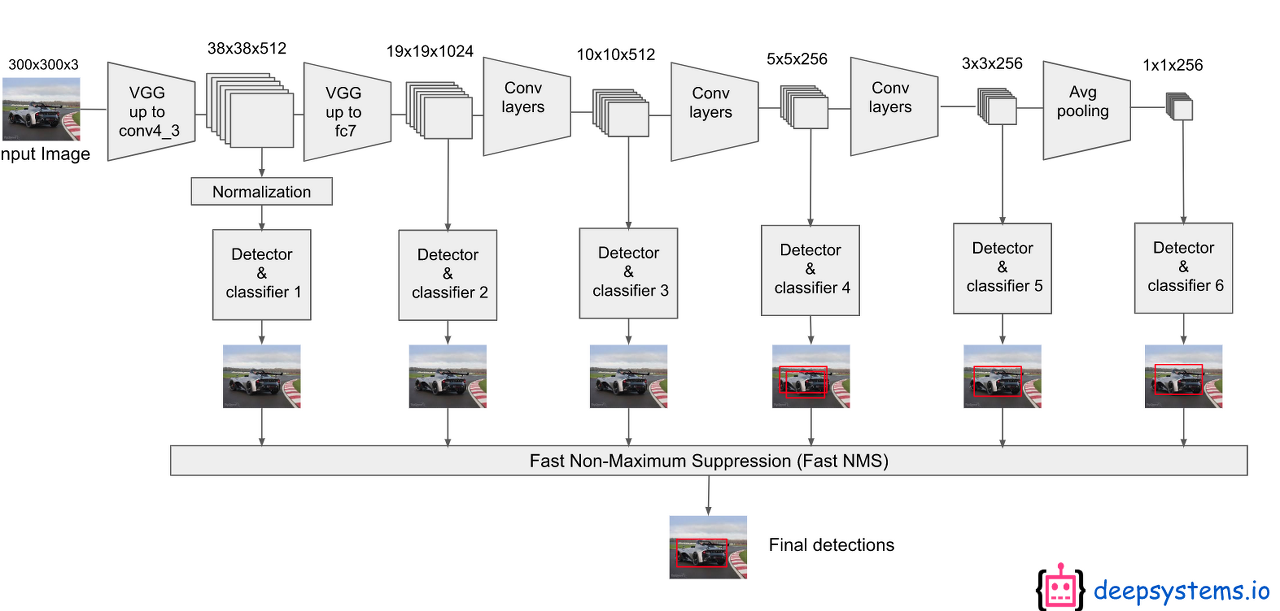

- SSD Structure vs YOLO Structure

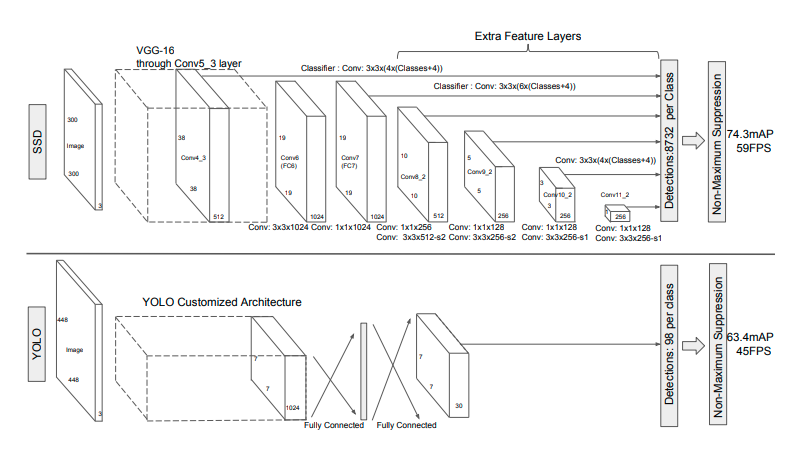

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
ROOT_PATH = '/gdrive/My Drive/Colab Notebooks/Lectures/085-088/'
data_dir = '{}{}'.format(ROOT_PATH, 'data/')
weights_dir = '{}{}'.format(ROOT_PATH, 'weights/')

In [3]:
!pwd
%cd /gdrive/My\ Drive/Colab\ Notebooks/Lectures/085-088/
!ls

/content
/gdrive/My Drive/Colab Notebooks/Lectures/085-088
'20210811(085)_0_make_folders_and_data_downloads.ipynb'
'20210811(085)_1_Dataset_DataLoader.ipynb'
'20210812(086)_2_SSD_model_forward.ipynb'
'20210812(086)_3_loss_function.ipynb'
'20210812(086)_4_SSD_training.ipynb'
'20210812(087)_5_SSD_inference_appendix.ipynb'
'20210812(087)_6_SSD_inference.ipynb'
'20210812(088)_0_make_folders_and_data_downloads.ipynb'
'20210812(088)_1_DataLoader.ipynb'
'20210812(088)_2_NetworkModel.ipynb'
'20210812(088)_3_PSPNet_training.ipynb'
'20210812(088)_4_PSPNet_inference_appendix.ipynb'
'20210812(088)_5_PSPNet_inference.ipynb'
 data
 utils085
 utils088
 weights


In [ ]:
# 패키지 import
from math import sqrt
from itertools import product

import pandas as pd
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

# vgg 모듈 구현

In [ ]:
# 34층에 걸쳐, vgg모듈을 작성
def make_vgg():
    layers = []
    in_channels = 3  # 색 채널 수 

    # vgg 모듈에서 사용하는 합성곱 층이나 맥스 풀링의 채널 수
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
           256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceil은 출력 크기를 계산 결과(float)에 대해, 소수점을 올려 정수로 하는 모드
            # 디폴트는 출력 크기를 계산 결과(float)에 대해, 소수점을 버려 정수로 하는 floor 모드
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)


# 동작 확인
vgg_test = make_vgg()
print(vgg_test)


ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

# extras 모듈 구현

In [ ]:
# 8층에 걸친 extras모듈 작성
def make_extras():
    layers = []
    in_channels = 1024  # vgg모듈에서 출력된, extra에 입력되는 화상 채널 수

    # extra모듈의 합성곱층의 채널수를 설정하는 구성(configuration)
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]
    
    # 활성화 함수의 ReLU는 이번에는 SSD모듈의 순전파 속에서 준비하는 것으로 하고,
    # extra모듈에서는 준비하지 않음

    return nn.ModuleList(layers)

# 동작 확인
extras_test = make_extras()
print(extras_test)


ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


# loc 및 conf 모듈 구현

In [ ]:
# 디폴트 박스의 오프셋을 출력하는 loc_layers,
# 디폴트 박스에 대한 각 클래스의 신뢰도 confidence를 출력하는 conf_layers를 작성
def make_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):

    loc_layers = []
    conf_layers = []

    # VGG의 22층, conv4_3(source1)에 대한 합성곱층
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                              * num_classes, kernel_size=3, padding=1)]

    # VGG의 최종층(source2)에 대한 합성곱층
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                              * num_classes, kernel_size=3, padding=1)]

    # extra(source3)에 대한 합성곱층
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                              * num_classes, kernel_size=3, padding=1)]

    # extra(source4)에 대한 합성곱층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                              * num_classes, kernel_size=3, padding=1)]

    # extra(source5)에 대한 합성곱층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                              * num_classes, kernel_size=3, padding=1)]

    # extra(source6)에 대한 합성곱층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                              * num_classes, kernel_size=3, padding=1)]

    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)


# 동작 확인
loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)


ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


# L2Norm 층 구현

In [ ]:
# convC4_3로부터의 출력을 scale=20의 L2Norm으로 정규화하는 층
class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()  # 부모 클래스의 생성자 실행
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale  # 계수 weight의 초기값으로 설정할 값
        self.reset_parameters()  # 파라미터의 초기화
        self.eps = 1e-10

    def reset_parameters(self):
        '''결합 파라미터의 scale크기 값으로 초기화 실행'''
        init.constant_(self.weight, self.scale)  # weight의 값이 모두 scale(=20)이 된다

    def forward(self, x):
        '''38×38의 특징량에 대해 512 채널에 걸쳐 제곱합의 루트를 구했다
        38×38개의 값을 사용하여 각 특징량을 정규화한 후 계수를 곱하여 계산하는 층'''

        # 각 채널에서의 38×38개의 특징량의 채널 방향의 제곱합을 계산하고,
        # 또한 루트를 구해 나누어 정규화한다
        # norm의 텐서 사이즈는 torch.Size([batch_num, 1, 38, 38])입니다
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)

        # 계수를 곱한다. 계수는 채널마다 하나로, 512개의 계수를 갖는다
        # self.weight의 텐서 사이즈는 torch.Size([512])이므로
        # torch.Size([batch_num, 512, 38, 38])까지 변형합니다
        weights = self.weight.unsqueeze(
            0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x

        return out


# 디폴트 박스 구현

In [ ]:
# 디폴트 박스를 출력하는 클래스
class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()

        # 초기설정
        self.image_size = cfg['input_size']  # 화상 크기 300
        # [38, 19, …] 각 source의 특징량 맵의 크기
        self.feature_maps = cfg['feature_maps']
        self.num_priors = len(cfg["feature_maps"])  # source의 개수 6
        self.steps = cfg['steps']  # [8, 16, …] DBox의 픽셀 크기
        
        self.min_sizes = cfg['min_sizes']
        # [30, 60, …] 작은 정사각형의 DBox 픽셀 크기(정확히는 면적)
        
        self.max_sizes = cfg['max_sizes']
        # [60, 111, …] 큰 정사각형의 DBox 픽셀 크기(정확히는 면적)
        
        self.aspect_ratios = cfg['aspect_ratios']  # 정사각형의 DBox의 화면비(종횡비)

    def make_dbox_list(self):
        '''DBox를 작성한다'''
        mean = []
        # 'feature_maps': [38, 19, 10, 5, 3, 1]
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):  # f까지의 수로 두 쌍의 조합을 작성한다 f_P_2개
                # 특징량의 화상 크기
                # 300 / 'steps': [8, 16, 32, 64, 100, 300],
                f_k = self.image_size / self.steps[k]

                # DBox의 중심 좌표 x,y. 0~1로 정규화되어 있음
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k

                # 화면비 1의 작은 DBox [cx,cy, width, height]
                # 'min_sizes': [30, 60, 111, 162, 213, 264]
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]

                # 화면비 1의 큰 DBox [cx,cy, width, height]
                # 'max_sizes': [60, 111, 162, 213, 264, 315],
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]

                # 그 외 화면비의 defBox [cx,cy, width, height]
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]

        # DBox를 텐서로 변환 torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)

        # DBox가 화상 밖으로 돌출되는 것을 막기 위해, 크기를 최소 0, 최대 1로 한다
        output.clamp_(max=1, min=0)

        return output


In [ ]:
# 동작 확인

# SSD300 설정
ssd_cfg = {
    'num_classes': 21,  # 배경 클래스를 포함한 총 클래스 수
    'input_size': 300,  # 화상의 입력 크기
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 출력할 Box 화면비의 종류
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 각 source의 화상 크기
    'steps': [8, 16, 32, 64, 100, 300],  # DBOX의 크기를 정한다
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOX의 크기를 정한다
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOX의 크기를 정한다
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# DBox 작성
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# DBox 출력을 확인한다
pd.DataFrame(dbox_list.numpy())


,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,0.141421
4,0.040000,0.013333,0.100000,0.100000
5,0.040000,0.013333,0.141421,0.141421
6,0.040000,0.013333,0.141421,0.070711
7,0.040000,0.013333,0.070711,0.141421
8,0.066667,0.013333,0.100000,0.100000
9,0.066667,0.013333,0.141421,0.141421


# SSD 클래스 구현

In [ ]:
# SSD 클래스를 작성한다
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inference를 지정
        self.num_classes = cfg["num_classes"]  # 클래스 수 21

        # SSD 네트워크를 작성
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox 작성
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 추론시는 "Detect" 클래스를 준비합니다
        if phase == 'inference':
            self.detect = Detect()


# 동작 확인
ssd_test = SSD(phase="train", cfg=ssd_cfg)
print(ssd_test)


SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (17): Conv2d(256, 

# 여기부터 2.5절 순전파의 구현입니다

# decode 함수 구현

In [ ]:
# 오프셋 정보를 이용하여 DBox를 BBox로 변환하는 함수
def decode(loc, dbox_list):
    """
    오프셋 정보를 이용하여 DBox를 BBox로 변환한다.

    Parameters
    ----------
    loc:  [8732,4]
        SSD 모델로 추론하는 오프셋 정보.
    dbox_list: [8732,4]
        DBox 정보

    Returns
    -------
    boxes : [xmin, ymin, xmax, ymax]
        BBox 정보
    """

    # DBox는 [cx, cy, width, height]로 저장되어 있음
    # loc도 [Δcx, Δcy, Δwidth, Δheight]로 저장되어 있음

    # 오프셋 정보로 BBox를 구한다
    boxes = torch.cat((
        dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:],
        dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)
    # boxes의 크기는 torch.Size([8732, 4])가 됩니다

    # BBox의 좌표정보를 [cx, cy, width, height]에서 [xmin, ymin, xmax, ymax]으로 변경
    boxes[:, :2] -= boxes[:, 2:] / 2  # 좌표 (xmin,ymin)로 변환
    boxes[:, 2:] += boxes[:, :2]  # 좌표 (xmax,ymax)로 변환

    return boxes


# Non-Maximum Suppression을 실시하는 함수를 구현

In [ ]:
# Non-Maximum Suppression을 실시하는 함수
def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    """
    Non-Maximum Suppression을 실시하는 함수.
    boxes 중에서 겹치는(overlap 이상)의 BBox를 삭제한다.

    Parameters
    ----------
    boxes : [신뢰도 임계값(0.01)을 넘은 BBox 수,4]
        BBox 정보
    scores :[신뢰도 임계값(0.01)을 넘은 BBox 수]
        conf 정보

    Returns
    -------
    keep : 리스트
        conf의 내림차순으로 nms를 통과한 index가 저장됨
    count: int
        nms를 통과한 BBox 수
    """

    # return의 모형을 작성
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    # keep: torch.Size([신뢰도 임계값을 넘은 BBox 수]), 요소는 전부 0

    # 각 BBox의 면적 area를 계산
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    # boxes를 복사한다. 나중에 BBox 중복도(IOU) 계산시의 모형으로 준비
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    # socre를 오름차순으로 나열한다
    v, idx = scores.sort(0)

    # 상위 top_k개(200개)의 BBox의 index를 꺼낸다(200개 존재하지 않는 경우도 있음)
    idx = idx[-top_k:]

    # idx의 요소수가 0가 아닌 한 루프한다
    while idx.numel() > 0:
        i = idx[-1]  # conf의 최대 index를 i로

        # keep의 끝에 conf 최대 index를 저장
        # 이 index의 BBox와 크게 겹치는 BBox를 삭제
        keep[count] = i
        count += 1

        # 마지막 BBox인 경우 루프를 빠져나옴
        if idx.size(0) == 1:
            break

        # 현재 conf 최대의 index를 keep에 저장했으므로, idx를 하나 감소시킴
        idx = idx[:-1]

        # -------------------
        # 이제부터 keep에 저장한 BBox과 크게 겹치는 BBox를 추출하여 삭제한다
        # -------------------
        # 하나 감소시킨 idx까지의 BBox를, out으로 지정한 변수로 작성한다
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # 모든 BBox에 대해, 현재 BBox=index가 i로 겹치는 값까지로 설정(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # w와 h의 텐서 크기를 index를 하나 줄인 것으로 한다
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clamp한 상태에서 BBox의 폭과 높이를 구한다
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # 폭이나 높이가 음수인 것은 0으로 한다
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clamp된 상태의 면적을 구한다
        inter = tmp_w*tmp_h

        # IoU = intersect부분 / (area(a) + area(b) - intersect부분)의 계산
        rem_areas = torch.index_select(area, 0, idx)  # 각 BBox의 원래 면적
        union = (rem_areas - inter) + area[i]  # 두 구역의 합(OR)의 면적
        IoU = inter/union

        # IoU가 overlap보다 작은 idx만 남긴다
        idx = idx[IoU.le(overlap)]  # le은 Less than or Equal to 처리를 하는 연산입니다
        # IoU가 overlap보다 큰 idx는 처음 선택한 keep에 저장한 idx과 동일한 물체에 대해 BBox를 둘러싸고 있으므로 삭제

    # while 루프에서 빠져나오면 종료

    return keep, count


# Detect 클래스 구현

In [ ]:
# SSD 추론시에 conf와 loc의 출력에서 겹침(중복)을 제거한 BBox를 출력한다
class Detect(Function):

    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)  # conf를 소프트맥스 함수로 정규화하기 위해 준비
        self.conf_thresh = conf_thresh  # conf가 conf_thresh=0.01보다 높은 DBox만을 취급
        self.top_k = top_k  # nm_supression으로 conf가 높은 top_k개의 계산에 사용하는, top_k = 200
        self.nms_thresh = nms_thresh  # nm_supression으로 IOU가 nms_thresh=0.45보다 크면 동일한 물체의 BBox로 간주

    def forward(self, loc_data, conf_data, dbox_list):
        """
        순전파 계산을 수행한다.

        Parameters
        ----------
        loc_data:  [batch_num,8732,4]
            오프셋 정보
        conf_data: [batch_num, 8732,num_classes]
            감지 신뢰도
        dbox_list: [8732,4]
            DBox의 정보

        Returns
        -------
        output : torch.Size([batch_num, 21, 200, 5])
            (batch_num, 클래스, conf의 top200, BBox 정보)
        """

        # 각 크기를 취득
        num_batch = loc_data.size(0)  # 미니 배치 크기
        num_dbox = loc_data.size(1)  # DBox 수 = 8732
        num_classes = conf_data.size(2)  # 클래스 수 = 21

        # conf는 소프트맥스를 적용하여 정규화한다
        conf_data = self.softmax(conf_data)

        # 출력 형식을 작성한다. 텐서 크기는 [minibatch수, 21, 200, 5]
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)

        # cof_data를 [batch_num,8732,num_classes]에서 [batch_num, num_classes,8732]에 순서 변경
        conf_preds = conf_data.transpose(2, 1)

        # 미니 배치마다 루프
        for i in range(num_batch):

            # 1. loc와 DBox로 수정한 BBox [xmin, ymin, xmax, ymax] 를 구한다
            decoded_boxes = decode(loc_data[i], dbox_list)

            # conf의 복사본을 작성
            conf_scores = conf_preds[i].clone()

            # 화상 클래스별 루프(배경 클래스의 index인 0은 계산하지 않고, index=1부터)
            for cl in range(1, num_classes):

                # 2.conf의 임계값을 넘은 BBox를 꺼낸다
                # conf의 임계값을 넘고 있는지에 대한 마스크를 작성하여,
                # 임계값을 넘은 conf의 인덱스를 c_mask로 취득
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                # gt는 Greater than을 의미. gt에 의해 임계값을 넘은 것이 1, 이하는 0이 된다.
                # conf_scores:torch.Size([21, 8732])
                # c_mask:torch.Size([8732])

                # scores는 torch.Size([임계값을 넘은 BBox 수])
                scores = conf_scores[cl][c_mask]

                # 임계값을 넘은 conf가 없는 경우, 즉 scores=[]의 경우에는 아무것도 하지 않는다
                if scores.nelement() == 0:  # nelement로 요소수의 함계를 구한다
                    continue

                # c_mask를 decoded_boxes에 적용할 수 있도록 크기를 변경합니다
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # l_mask:torch.Size([8732, 4])

                # l_mask를 decoded_boxes로 적용합니다
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # decoded_boxes[l_mask]로 1차원이 되어버리기 때문에,
                # view에서 (임계값을 넘은 BBox 수, 4) 크기로 변형한다

                # 3. Non-Maximum Suppression를 실시하여, 겹치는 BBox를 제거
                ids, count = nm_suppression(
                    boxes, scores, self.nms_thresh, self.top_k)
                # ids: conf의 내림차순으로 Non-Maximum Suppression를 통과한 index가 저장됨
                # count: Non-Maximum Suppression를 통과한 BBox 수

                # output에 Non-Maximum Suppression를 뺀 결과를 저장
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1),
                                                   boxes[ids[:count]]), 1)

        return output  # torch.Size([1, 21, 200, 5])


# SSD 클래스 구현

In [ ]:
# SSD 클래스를 작성한다
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inference를 지정
        self.num_classes = cfg["num_classes"]  # 클래스 수=21

        # SSD 네트워크를 만든다
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox 작성
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 추론시에는 "Detect" 클래스를 준비합니다
        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = list()  # loc와 conf로의 입력 source1-6을 저장
        loc = list()  # loc의 출력을 저장
        conf = list()  # conf의 출력을 저장

        # vgg의 conv4_3까지 계산한다
        for k in range(23):
            x = self.vgg[k](x)

        # conv4_3의 출력을 L2Norm에 입력하고, source1을 작성하여, sources에 추가
        source1 = self.L2Norm(x)
        sources.append(source1)

        # vgg를 끝까지 계산하여, source2를 작성하고, sources에 추가
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        # extras의 conv와 ReLU를 계산
        # source3~6을 sources에 추가
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv→ReLU→cov→ReLU를 하여 source에 넣는다
                sources.append(x)

        # source1~6에 각각 대응하는 합성곱을 1회씩 적용한다
        # zip으로 for 루프의 여러 리스트 요소를 취득
        # source1~6까지 있으므로 루프가 6회 실시됨
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # Permute으로 요소의 순서를 교체
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x)와 c(x)으로 합성곱을 실행
            # l(x)와 c(x)의 출력 크기는 [batch_num, 4*화면비의 종류 수, featuremap 높이, featuremap 폭]
            # source에 따라 화면비의 종류 수가 다르며, 번거로우므로 순서 교체로 조정한다
            # permute로 요소 순서를 교체하여,
            # [minibatch 수, featuremap 수, featuremap 수, 4*화면비의 종류 수]으로
            # (주석)
            # torch.contiguous()은 메모리 상에 요소를 연속적으로 배치하는 명령입니다
            # 다음으로 view 함수를 사용합니다.
            # 이 view를 수행하기 때문에, 대상의 변수가 메모리 상에 연속적으로 배치되어 있어야 합니다.

        # 또한 loc와 conf의 형을 변형
        # loc의 크기는 torch.Size([batch_num, 34928])
        # conf의 크기는 torch.Size([batch_num, 183372])가 된다
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        # 그리고 loc와 conf의 형을 변형
        # loc의 크기는 torch.Size([batch_num, 8732, 4])
        # conf의 크기는 torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # 마지막으로 출력한다
        output = (loc, conf, self.dbox_list)

        if self.phase == "inference":  # 추론시
            # "Detect" 클래스의 forward를 실행
            # 반환값의 크기는 torch.Size([batch_num, 21, 200, 5])
            return self.detect(output[0], output[1], output[2])

        else:  # 학습시
            return output
            # 반환값은 (loc, conf, dbox_list)의 튜플


끝